<a href="https://colab.research.google.com/github/arpita0911patel/Building-A-Community/blob/main/Google_Flood_Forecasting_API_Usage_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flood Forecasting API

Official documentations page https://developers.google.com/flood-forecasting

The Flood Forecasting API provides an interface to access real time riverine flood forecasts, which is also available on the [Flood Hub](https://g.co/floodhub).

For historical data, refer to our publicly available datasets:

*   [Inundation History dataset](https://console.cloud.google.com/storage/browser/flood-forecasting/inundation_history) which contains information on water occurancy around the world (1999 - 2020)
*   [Google Runoff Reanalysis & Reforecast dataset (GRRR)](https://colab.research.google.com/drive/1FnXXSEQqU1TJhMPiNeWUTr9LnbJwZzMm?usp=sharing#scrollTo=UTbokLLWp_9o) global river discharge estimates (1980-2023)


For more details about the research and publications underlying the datasets, visit our [website](https://sites.research.google/gr/floodforecasting/). The data exposed by this API is under the [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license and offered at no charge.

# API access
To get started, fill out [the waitlist form](https://docs.google.com/forms/d/e/1FAIpQLSfcKhe3CHsncM-_NQ66zLheEfXKnNbDPBtuIT7BSYCqYkmOaA/viewform) to join the waiting list. Once approved, we'll send you an email. If you've already received your approval email, reply to it with your **Google Cloud Project ID** (more details below).

The Flood Forecasting API is public and offered at no charge. Accessing the Flood Forecasting API requires an API key and enabling the Flood Forecasting API.

Once you have an API key and have enabled the Flood Forecasting API, you can verify API access by running this colab notebook.



## API keys
If you use Google Cloud or other Google Developer services, you can use those existing API keys or make a new one.
If you don't have any Google API keys, you will need to:

*   [Create a Google Cloud Account](https://cloud.google.com/resource-manager/docs/creating-managing-projects)
*   [Create an API key](https://support.google.com/googleapi/answer/6158862)

## Enable Flood Forecasting API
To enable the Flood Forecasting API, navigate to the [Flood Forecasting API page](https://console.cloud.google.com/apis/library/floodforecasting.googleapis.com) and click the `Enable` button.

If you cannot access this page, it likely means you have not yet been added as a Service Consumer. First, please verify that you are logged in with the correct email address you provided to us. If you are using the correct email address and still lack access, please contact floods-api-pilot@google.com for assistance.

For more general information about enabling APIs, please see this [guide](https://support.google.com/googleapi/answer/6158841).

## Add your key to Colab Secrets

Add your API key to the Colab Secrets manager to securely store it.

1. Open your Google Colab notebook and click on the 🔑 **Secrets** tab in the left panel.
   
   <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>

2. Create a new secret with the name `FLOODS_API_KEY`.
3. Copy/paste your API key into the `Value` input box of `FLOODS_API_KEY`.
4. Toggle the button on the left to allow notebook access to the secret.



# Getting Started

Run the following cells for the imports, reading the API key and setting the country code we'll use for the demo.

In [ ]:
import geopandas as gpd
from shapely import geometry
import requests
import datetime
import pprint
import matplotlib.pyplot as plt
from google.colab import userdata
from tqdm import tqdm
import json

In [ ]:
KEY = userdata.get('FLOODS_API_KEY')

In [ ]:
region_code = 'US'
iso_a3_country_code = 'USA'
page_size = 10000

# Flood Status API

[Doc page](https://developers.google.com/flood-forecasting/rest/v1/floodStatus)

This API exposes most of the data available on the http://g.co/floodhub

Please reach out if you're missing any data or have some other feature requests.

## Find Flood Status for Region

In [ ]:
flood_statuses = []
request = {
    'regionCode': region_code,
    'pageSize': page_size,
    'includeNonQualityVerified': False,  # Set to True to include low-confidance gauges.
}

with tqdm() as pbar:  # Init progress bar
  while True:
    region_flood_statuses_response = requests.post(
        f'https://floodforecasting.googleapis.com/v1/floodStatus:searchLatestFloodStatusByArea?key={KEY}',
        json=request
    ).json()
    if 'error' in region_flood_statuses_response:
      print(region_flood_statuses_response)
      break
    new_floods_status = region_flood_statuses_response.get('floodStatuses', [])
    pbar.update(len(new_floods_status))  # Update progress bar
    flood_statuses.extend(new_floods_status)
    nextPageToken = region_flood_statuses_response.get('nextPageToken')
    if not nextPageToken:
      break
    request['pageToken'] = nextPageToken

print()  # Break line
if flood_statuses:
  print(json.dumps(flood_statuses[0], indent=4))

1234it [00:03, 346.36it/s]


{'gaugeId': 'hybas_7120624340', 'issuedTime': '2025-10-22T06:48:26.389635Z', 'forecastTimeRange': {'start': '2025-10-26T00:00:00Z', 'end': '2025-10-27T00:00:00Z'}, 'forecastTrend': 'NO_CHANGE', 'severity': 'NO_FLOODING', 'source': 'HYBAS', 'gaugeLocation': {'latitude': 36.53958333333191, 'longitude': -105.7062500000012}, 'qualityVerified': True}


## Plot

### Split to different severity buckets

In [ ]:
unknown_flood_status_points = []
under_warning_points = []
warning_points = []
danger_points = []
extreme_points = []

for status in flood_statuses:
  gaugeLocation = status['gaugeLocation']
  match status['severity']:
    case 'UNKNOWN':
      unknown_flood_status_points.append(gaugeLocation)
    case 'NO_FLOODING':
      under_warning_points.append(gaugeLocation)
    case 'ABOVE_NORMAL':
      warning_points.append(gaugeLocation)
    case 'SEVERE':
      danger_points.append(gaugeLocation)
    case 'EXTREME':
      extreme_points.append(gaugeLocation)

### Helper functions for plotting

In [ ]:
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")

def get_country_multi_polygon(iso_a3_country_code: str):
  country_record = world[world.ADM0_A3 == iso_a3_country_code]
  if len(country_record) != 1:
    raise ValueError(f'Country {iso_a3_country_code} is not found.')
  country_geometry = country_record.iloc[0].geometry
  if isinstance(country_geometry, geometry.MultiPolygon):
    return country_geometry
  return geometry.MultiPolygon([country_geometry])

def get_country_contours(iso_a3_country_code: str):
  country_geometry = get_country_multi_polygon(iso_a3_country_code)
  return [list(p.exterior.coords) for p in country_geometry.geoms]

def plot_points(ax, points, color):
  for point in points:
    lat = point['latitude']
    lng = point['longitude']
    ax.plot(lng, lat, 'o', color=color)

def plot_country(ax, iso_a3_country_code):
  country_multipolygon = get_country_multi_polygon(iso_a3_country_code)
  for polygon in country_multipolygon.geoms:
    all_lngs, all_lats = polygon.exterior.xy
    ax.plot(all_lngs, all_lats, color='black')
    ax.fill(all_lngs, all_lats, alpha=0.1, color='blue')

### Plot gauges

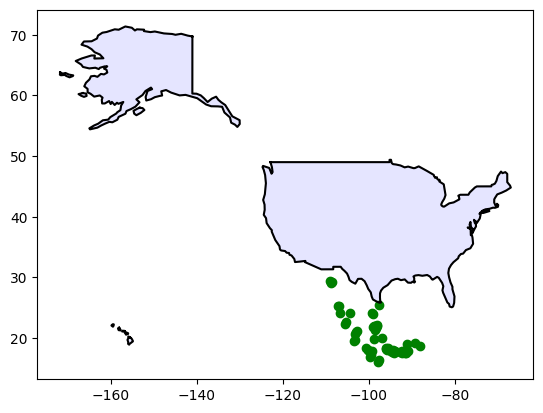

In [ ]:
fig, ax = plt.subplots()

plot_points(ax, unknown_flood_status_points, 'gray')
plot_points(ax, under_warning_points, 'green')
plot_points(ax, warning_points, 'orange')
plot_points(ax, danger_points, 'red')
plot_points(ax, extreme_points, 'purple')
plot_country(ax, iso_a3_country_code)

## Fetch Polygons

### Search for a flood status with a risk map and another one with a notification map



Note that in the following sections we assume that at least one of the flood statuses has an inundation map. But this is not always the case.

Also, some flood statuses may have a risk map but are lacking a notification map.

In [ ]:
inundation_map_set = None
for status in flood_statuses:
  if 'inundationMapSet' in status and status['inundationMapSet']:
    inundation_map_set = status['inundationMapSet']
    break
if not inundation_map_set:
  print('No inundation map found.')

No inundation map found.


In [ ]:
serialized_notification_polygon_id = None
for status in flood_statuses:
  if 'serializedNotificationPolygonId' in status and status['serializedNotificationPolygonId']:
    serialized_notification_polygon_id = status['serializedNotificationPolygonId']
    break
if not serialized_notification_polygon_id:
  print('No notification polygon found.')

No notification polygon found.


### Fetch the KMLs for all the risk levels

In [ ]:
level_to_polygon_id = {}
if inundation_map_set:
  for inundation_map in inundation_map_set['inundationMaps']:
    level = inundation_map['level']
    level_to_polygon_id[level] = inundation_map['serializedPolygonId']

In [ ]:
level_to_kml = {}
for level, serialized_polygon_id in level_to_polygon_id.items():
  serialized_polygon_response = requests.get(
      f'https://floodforecasting.googleapis.com/v1/serializedPolygons/{serialized_polygon_id}?key={KEY}').json()
  if 'error' in serialized_polygon_response:
    print(serialized_polygon_response)
    break
  level_to_kml[level] = serialized_polygon_response['kml']

In [ ]:
for level, kml in level_to_kml.items():
  with open(f'level_{level}.kml', 'w') as f:
    f.write(kml)

In [ ]:
gdf = gpd.read_file(f'level_MEDIUM.kml', driver='KML')

gdf.plot()

### You should be able to see and download the files from the colab Files explorer

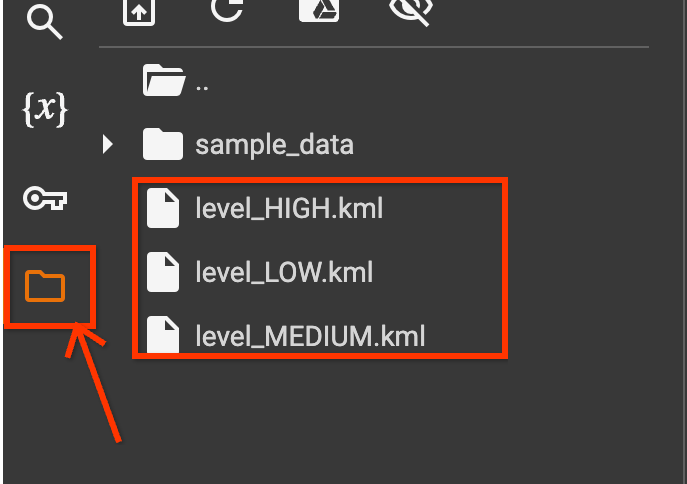

### Fetch the notification polygon

In [ ]:
if not serialized_notification_polygon_id:
  print('No notification polygon found.')
serialized_polygon_response = requests.get(
    f'https://floodforecasting.googleapis.com/v1/serializedPolygons/{serialized_notification_polygon_id}?key={KEY}').json()
if 'error' in serialized_polygon_response:
  print(f'Error fetching notification polygon: {serialized_polygon_response["error"]}')
else:
  notification_kml = serialized_polygon_response['kml']
  with open(f'notification.kml', 'w') as f:
    f.write(notification_kml)

No notification polygon found.
Error fetching notification polygon: {'code': 404, 'message': 'Requested entity was not found.', 'status': 'NOT_FOUND'}


In [ ]:
gdf = gpd.read_file(f'level_MEDIUM.kml', driver='KML')

gdf.plot()

You should be able to see and download the files from the colab Files tab (see image above)

# Hydrology Model API

This API provides access to our models' forecasts **starting from 2023-10-01**.

For global river discharge estimates from earlier periods (1980-2023), please refer to the [Google Runoff Reanalysis & Reforecast dataset (GRRR)](https://colab.research.google.com/drive/1FnXXSEQqU1TJhMPiNeWUTr9LnbJwZzMm?usp=sharing#scrollTo=UTbokLLWp_9o).

**To retrieve forecasts using this API:**

1.  Find the required gauges/hybases.
2.  Retrieve the models' output for a specific time period (on or after 2023-10-01).
3.  Fetch the corresponding gauge model's metadata and return-period values.

## Search for Gauges or Hybases

In [ ]:
request = {
    'regionCode': region_code,
    'pageSize': page_size,
    'includeNonQualityVerified': False,  # Set to True to include low-confidance gauges.
}
gauges = []
with tqdm() as pbar:  # Initializing progress bar
  while True:
    res = requests.post(
        f'https://floodforecasting.googleapis.com/v1/gauges:searchGaugesByArea?key={KEY}',
        json=request
    ).json()
    if 'error' in res:
      print(res)
      break
    if 'gauges' in res:
      gauges.extend(res['gauges'])

    if 'nextPageToken' not in res or not res['nextPageToken']:
      break
    request['pageToken'] = res['nextPageToken']
    pbar.update(1)  # Updating progress bar

print(f'\nFound {len(gauges)} gauges')
if gauges:
  print(f'Printing one gauge for example:')
  pprint.pprint(gauges[0])



1it [00:01,  1.50s/it]


Found 1234 gauges
Printing one gauge for example:
{'gaugeId': 'hybas_7120014520',
 'hasModel': True,
 'location': {'latitude': 43.69791666666498, 'longitude': -124.1687500000009},
 'qualityVerified': True,
 'river': '',
 'siteName': '',
 'source': 'HYBAS'}


## Fetch Model Forecasts

Here we fetch all the forecasts that were issued by the models for a given period of time. Note that every forecast has multiple lead times.

In [ ]:
GAUGE_BUCKET_SIZE = 500

# Only fetch forecasts for gauges with models.
gauge_ids = [g['gaugeId'] for g in gauges]

# Fetch gauge forecasts in small buckets, due to the endpoint limit of maximum allowed gauges per request.
gauge_id_buckets = [gauge_ids[i:i + GAUGE_BUCKET_SIZE] for i in range(0, len(gauge_ids), GAUGE_BUCKET_SIZE)]

last_week = datetime.datetime.now() - datetime.timedelta(days=7)
tommorow = datetime.datetime.now() + datetime.timedelta(days=1)

forecasts = {}
for gauge_bucket in tqdm(gauge_id_buckets):
  res = requests.get(
      f'https://floodforecasting.googleapis.com/v1/gauges:queryGaugeForecasts',
      params={
          'key': KEY,
          'gaugeIds': gauge_bucket,
          'issuedTimeStart': last_week.strftime('%Y-%m-%d'),
          'issuedTimeEnd': tommorow.strftime('%Y-%m-%d'),
      },
  ).json()
  if res and 'forecasts' in res:
    forecasts.update(res['forecasts'])

100%|██████████| 3/3 [00:07<00:00,  2.54s/it]


In [ ]:
print(f'Found forecasts for {len(forecasts)} gauges.')
gauge_id = gauges[0]['gaugeId'] # Pick random gauge to show forecasts for.
print(f'Found {len(forecasts[gauge_id]["forecasts"])} forecasts that were issued for gauge {gauge_id} between {last_week.date()} and {tommorow.date()}')
print(f'\nPrinting the first forcast, note that the forecast has multiple lead times (called forecastRanges)')
pprint.pprint(forecasts[gauge_id]["forecasts"][0])

Found forecasts for 1234 gauges.
Found 8 forecasts that were issued for gauge hybas_7120014520 between 2025-10-15 and 2025-10-23

Printing the first forcast, note that the forecast have multple lead times (called forecastRanges)
{'forecastRanges': [{'forecastEndTime': '2025-10-14T00:00:00Z',
                     'forecastStartTime': '2025-10-13T00:00:00Z',
                     'value': 55.271854400634766},
                    {'forecastEndTime': '2025-10-15T00:00:00Z',
                     'forecastStartTime': '2025-10-14T00:00:00Z',
                     'value': 64.73954010009766},
                    {'forecastEndTime': '2025-10-16T00:00:00Z',
                     'forecastStartTime': '2025-10-15T00:00:00Z',
                     'value': 56.820316314697266},
                    {'forecastEndTime': '2025-10-17T00:00:00Z',
                     'forecastStartTime': '2025-10-16T00:00:00Z',
                     'value': 50.244171142578125},
                    {'forecastEndTime': '2025-10

## Fetch Gauge Model Metadata

The model metadata contains some useful information. Most importantly, the thresholds for warning, danger and extreme danger.

**Note that for models that predict water level meters, the thresholds are meters provided by local authorities. For models that predict cubic meters per second (discharge), the thresholds are 2, 5 and 20 years return period.**

In [ ]:
GAUGE_MODEL_BUCKET_SIZE = 50

# Only fetch models metadata for gauges with models.
gauge_ids = [g['gaugeId'] for g in gauges]

# Fetch gauge models in small buckets, due to the endpoint limit of maximum allowed models per request.
gauge_id_buckets = [gauge_ids[i:i + GAUGE_MODEL_BUCKET_SIZE] for i in range(0, len(gauge_ids), GAUGE_MODEL_BUCKET_SIZE)]

gauges_models = []
for gauge_id_bucket in tqdm(gauge_id_buckets):
  model_names = [f'names=gaugeModels/{g}' for g in gauge_id_bucket]
  res = requests.get(f'https://floodforecasting.googleapis.com/v1/gaugeModels:batchGet?key={KEY}&{"&".join(model_names)}').json()
  gauges_models.extend(res['gaugeModels'] if res and 'gaugeModels' in res else [])

print(f'\nFetched {len(gauges_models)} gauge models.')
if gauges_models:
  pprint.pprint(gauges_models[0])

100%|██████████| 25/25 [00:11<00:00,  2.15it/s]


Fetched 1234 gauge models.
{'gaugeId': 'hybas_7120334190',
 'gaugeModelId': 'f59c92096f1e596b8760518421d6d9b82880c9b1d1d946f52cddab45702247ef',
 'gaugeValueUnit': 'CUBIC_METERS_PER_SECOND',
 'qualityVerified': True,
 'thresholds': {'dangerLevel': 805.8919677734375,
                'extremeDangerLevel': 1353.28076171875,
                'warningLevel': 419.50506591796875}}


# Significant Events API

Areas at high risk of major flood events. Uses gauge based discharge predictions, clustered for basins exceeding danger level thresholds. Incorporates the area of impact and the population within that area.

Marked as pulsing red circles on [g.co/floodhub](https://g.co/floodhub)

In [ ]:
significant_events = []
request = {}

while True:
  res = requests.post(
      f'https://floodforecasting.googleapis.com/v1/significantEvents:search?key={KEY}',
      json=request
  )
  significant_events_response = res.json()
  if 'error' in significant_events_response:
    print(significant_events_response)
    break
  significant_events.extend(significant_events_response.get('significantEvents', []))
  nextPageToken = significant_events_response.get('nextPageToken')
  if not nextPageToken:
    break
  request['pageToken'] = nextPageToken

significant_events

[{'eventInterval': {'startTime': '2025-10-23T00:00:00Z',
   'minimumEndTime': '2025-11-02T00:00:00Z'},
  'affectedCountryCodes': ['HT', 'DO'],
  'affectedPopulation': 4115374,
  'areaKm2': 15143.323,
  'gaugeIds': ['hybas_7120071270',
   'hybas_7120072760',
   'hybas_7120071110',
   'hybas_7120071010',
   'hybas_7120080490',
   'hybas_7120070960',
   'hybas_7120071060',
   'hybas_7120071150',
   'hybas_7120070830',
   'hybas_7120071420',
   'hybas_7120071370',
   'hybas_7120071200',
   'hybas_7120070910',
   'hybas_7120072720',
   'hybas_7120071560',
   'hybas_7120070940',
   'hybas_7120071350',
   'hybas_7120071170',
   'hybas_7120071080',
   'hybas_7120081430',
   'hybas_7120072740',
   'hybas_7120072620',
   'hybas_7120071450',
   'hybas_7120070890',
   'hybas_7120070870',
   'hybas_7120071470',
   'hybas_7120071300',
   'hybas_7120072700',
   'hybas_7120071040',
   'hybas_7120072590',
   'hybas_7120072570',
   'hybas_7120071220',
   'hybas_7120080250',
   'hybas_7120842710',
   'hy

## Fetch event's polygon

In [ ]:
if not significant_events:
  print('No significant events found')
else:
  event = significant_events[0]
  serialized_polygon_response = requests.get(
      f'https://floodforecasting.googleapis.com/v1/serializedPolygons/{event['eventPolygonId']}?key={KEY}').json()
  if 'error' in serialized_polygon_response:
    print(f'Error fetching polygon: {serialized_polygon_response["error"]}')
  else:
    with open(f'significant_event_polygon.kml', 'w') as f:
      f.write(serialized_polygon_response['kml'])

In [ ]:
gdf = gpd.read_file(f'significant_event_polygon.kml', driver='KML')

gdf.plot()